# **ML Project nr. 5 - Predict the likelihood of a patient having a stroke based on health data**

# *Basic imports*

In [98]:
import random
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File Handling (Google Colab)
from google.colab import files

# Sklearn Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import resample

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

*Setting seed for reproducibility*

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

***Dataset used from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data. You have to download the dataset and chose it in the cell below***

*Uploading stroke 'data.csv' file from pc*

In [3]:
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (3).csv


# **Loading and understanding dataset**



In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


## **Info**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Checking for missing data

In [6]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


***The amount of missing data is small, about 4% (201/5110), so it's better to fill in the missing values rather than drop the rows***

## Target – how many people had a stroke and how many did not

In [7]:
df["stroke"].value_counts()

,count
stroke,
0,4861
1,249




---



# **Data preparation**

## **Filling the missing data in bmi - mediana**

In [8]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

/tmp/ipython-input-1439978410.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


*Checking if everything worked right*

In [9]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


## **Converting text to numbers**

In [10]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [11]:
df.head(10)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False
5,56669,81.0,0,0,186.21,29.0,1,True,False,True,False,True,False,False,True,True,False,False
6,53882,74.0,1,1,70.09,27.4,1,True,False,True,False,True,False,False,False,False,True,False
7,10434,69.0,0,0,94.39,22.8,1,False,False,False,False,True,False,False,True,False,True,False
8,27419,59.0,0,0,76.15,28.1,1,False,False,True,False,True,False,False,False,False,False,False
9,60491,78.0,0,0,58.57,24.2,1,False,False,True,False,True,False,False,True,False,False,False


## **Scaling**

In [12]:
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [13]:
scaler = StandardScaler()
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols] = scaler.fit_transform(df[num_cols])

**Checking if everything worked**

In [14]:
df.head(10)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1.051434,0,1,2.706375,1.005086,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,0.786070,0,0,2.121559,-0.098981,1,False,False,True,False,False,True,False,False,False,True,False
2,31112,1.626390,0,1,-0.005028,0.472536,1,True,False,True,False,True,False,False,False,False,True,False
3,60182,0.255342,0,0,1.437358,0.719327,1,False,False,True,False,True,False,False,True,False,False,True
4,1665,1.582163,1,0,1.501184,-0.631531,1,False,False,True,False,False,True,False,False,False,True,False
5,56669,1.670617,0,0,1.768195,0.017920,1,True,False,True,False,True,False,False,True,True,False,False
6,53882,1.361026,1,1,-0.796342,-0.189904,1,True,False,True,False,True,False,False,False,False,True,False
7,10434,1.139889,0,0,-0.259671,-0.787399,1,False,False,False,False,True,False,False,True,False,True,False
8,27419,0.697615,0,0,-0.662506,-0.098981,1,False,False,True,False,True,False,False,False,False,False,False
9,60491,1.537935,0,0,-1.050764,-0.605553,1,False,False,True,False,True,False,False,True,False,False,False


## **Data separation**

In [15]:
X = df.drop('stroke', axis=1)
X.head(10)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1.051434,0,1,2.706375,1.005086,True,False,True,False,True,False,False,True,True,False,False
1,51676,0.786070,0,0,2.121559,-0.098981,False,False,True,False,False,True,False,False,False,True,False
2,31112,1.626390,0,1,-0.005028,0.472536,True,False,True,False,True,False,False,False,False,True,False
3,60182,0.255342,0,0,1.437358,0.719327,False,False,True,False,True,False,False,True,False,False,True
4,1665,1.582163,1,0,1.501184,-0.631531,False,False,True,False,False,True,False,False,False,True,False
5,56669,1.670617,0,0,1.768195,0.017920,True,False,True,False,True,False,False,True,True,False,False
6,53882,1.361026,1,1,-0.796342,-0.189904,True,False,True,False,True,False,False,False,False,True,False
7,10434,1.139889,0,0,-0.259671,-0.787399,False,False,False,False,True,False,False,True,False,True,False
8,27419,0.697615,0,0,-0.662506,-0.098981,False,False,True,False,True,False,False,False,False,False,False
9,60491,1.537935,0,0,-1.050764,-0.605553,False,False,True,False,True,False,False,True,False,False,False


In [16]:
y = df['stroke']
y.head(10)

,stroke
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


## **Data splitting**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Model building and training with TensorFlow (Keras)**

## **Building the model**

In [99]:
keras_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

## **Compiling the model**

In [43]:
keras_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## **Training the model**

In [57]:
history = keras_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=25,
    verbose=1
)

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9422 - loss: 0.3285 - val_accuracy: 0.8411 - val_loss: 0.3550
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.4962 - val_accuracy: 0.9425 - val_loss: 0.4062
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9457 - loss: 0.3289 - val_accuracy: 0.9425 - val_loss: 0.8819
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9360 - loss: 0.4288 - val_accuracy: 0.9425 - val_loss: 0.2551
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.3318 - val_accuracy: 0.9425 - val_loss: 0.5039
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9456 - loss: 0.5761 - val_accuracy: 0.9425 - val_loss: 0.3650
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9335 - loss: 0.8494 - val_accuracy: 0.9425 - val_loss: 1.8582
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 2.2500 - val_accuracy: 0.

## **Evaluating on test data**

In [58]:
loss, accuracy = keras_model.evaluate(X_test, y_test)
print(f'Test accuracy:', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.1767 
Test accuracy: 0.951076328754425


## **Best model saving and loading**

### *Saving the model*

In [60]:
keras_model.save('stroke_model_best.keras')

### *Downloading the model*

In [61]:
files.download('stroke_model_best.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### *Loead the model. Also you can rerun the model*

In [65]:
# Load the model from file
keras_model = load_model('stroke_model_best.keras')

# Evaluate or use it as usual
loss, accuracy = keras_model.evaluate(X_test, y_test)
print("Loaded model accuracy:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.1767  
Loaded model accuracy: 0.951076328754425


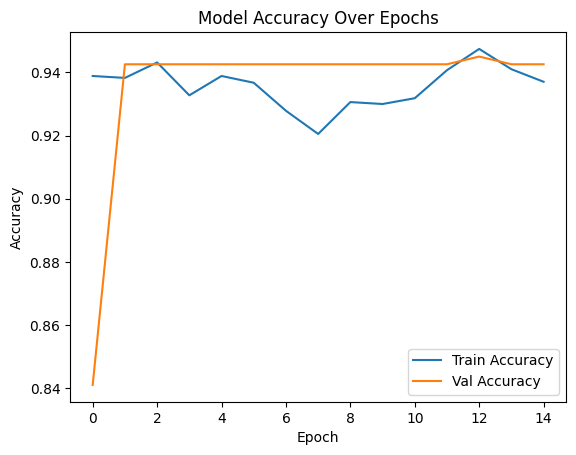

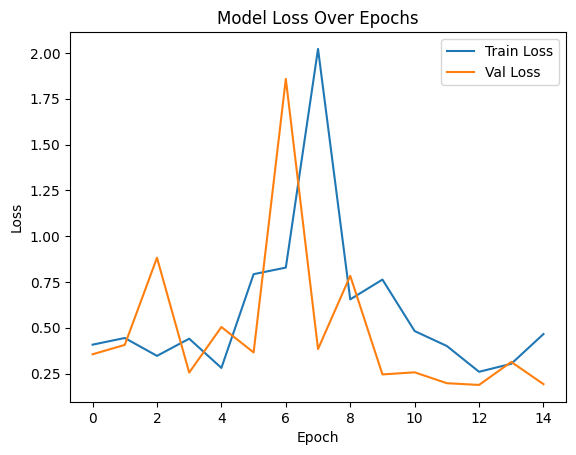

In [66]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

# **Reusing the data to build and train with Pytorch**

## **Converting the data types to float**

In [67]:
X_train.dtypes

,0
id,float32
age,float32
hypertension,float32
heart_disease,float32
avg_glucose_level,float32
bmi,float32
gender_Male,float32
gender_Other,float32
ever_married_Yes,float32
work_type_Never_worked,float32


*Converting data types from bool to float32*

In [68]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train.dtypes

,0
id,float32
age,float32
hypertension,float32
heart_disease,float32
avg_glucose_level,float32
bmi,float32
gender_Male,float32
gender_Other,float32
ever_married_Yes,float32
work_type_Never_worked,float32


## **Converting the data to PyTorch tensors**



In [76]:
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data['stroke'] == 0]
minority = train_data[train_data['stroke'] == 1]

minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=seed)

balanced_train = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=seed)


# Split again into features and labels
X_train_balanced = balanced_train.drop('stroke', axis=1)
y_train_balanced = balanced_train['stroke']

# Scale data
scaler = StandardScaler()
X_train_balanced = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_balanced.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Building the model**

In [77]:
class StrokePredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(StrokePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

## **Loss**

In [78]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

## Initialize

In [79]:
input_dim = X_train_tensor.shape[1]
model = StrokePredictionModel(input_dim)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## **Model training loop**

In [88]:
num_epochs = 15
threshold = 0.35

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f} — Accuracy: {epoch_acc:.4f}')

Epoch 1/15 — Loss: 0.0157 — Accuracy: 0.9643
Epoch 2/15 — Loss: 0.0147 — Accuracy: 0.9657
Epoch 3/15 — Loss: 0.0149 — Accuracy: 0.9675
Epoch 4/15 — Loss: 0.0156 — Accuracy: 0.9653
Epoch 5/15 — Loss: 0.0144 — Accuracy: 0.9680
Epoch 6/15 — Loss: 0.0141 — Accuracy: 0.9690
Epoch 7/15 — Loss: 0.0137 — Accuracy: 0.9720
Epoch 8/15 — Loss: 0.0124 — Accuracy: 0.9713
Epoch 9/15 — Loss: 0.0134 — Accuracy: 0.9708
Epoch 10/15 — Loss: 0.0114 — Accuracy: 0.9758
Epoch 11/15 — Loss: 0.0108 — Accuracy: 0.9761
Epoch 12/15 — Loss: 0.0106 — Accuracy: 0.9756
Epoch 13/15 — Loss: 0.0111 — Accuracy: 0.9769
Epoch 14/15 — Loss: 0.0105 — Accuracy: 0.9771
Epoch 15/15 — Loss: 0.0102 — Accuracy: 0.9780


## **Evaluating on test data**

In [91]:
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_logits.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_logits = np.array(all_logits).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

test_loss = running_loss / total
test_acc = correct /

#Tryed some different tresholds to see which one is the best for the model
print("🔍 Threshold Tuning:")
for threshold in np.arange(0.1, 0.91, 0.05):
    probs = torch.sigmoid(torch.tensor(all_logits))
    preds = (probs > threshold).float().numpy()
    print(f"\nThreshold: {threshold:.2f}")
    print(classification_report(all_labels, preds, digits=4))

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.0102, Test Accuracy: 0.9780


## Saving and loading the best model

### Model saving

In [92]:
torch.save(model.state_dict(), 'best_stroke_model_threshold_035.pth')
print("✅ Model saved as 'best_stroke_model_threshold_035.pth'")

✅ Model saved as 'best_stroke_model_threshold_035.pth'


### Loading the best model

In [93]:
model.load_state_dict(torch.load('best_stroke_model_threshold_035.pth'))
model.eval()

StrokePredictionModel(
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

# **Comparing a TF/keras and pytorch**

*As a beginner, I found TensorFlow/Keras easier to use because it comes with built-in training loops, evaluation tools, and many high-level abstractions. This makes it simpler to build, tune, and experiment with neural networks quickly.

On the other hand, PyTorch is more complex at first, since you have to manually write training loops, handle loss functions, and manage more low-level operations. This gives you more responsibility — but also much more flexibility when building and customizing neural networks.

Personally, Keras was easier to understand and get started with. But after working with both, I feel that PyTorch offers better control and is ultimately more powerful. So now, I’m leaning more toward using PyTorch hands-on.*